In [1]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 16px; }</style>")) # Increase font size

# Matplotlib conf
import matplotlib.pyplot as plt
%matplotlib inline

# Seaborn conf
import seaborn as sns
sns.set_palette(sns.color_palette("seismic"))

import sys

import pandas as pd
import numpy as np
import operator
import string
import nltk

import pandas 
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.naive_bayes import MultinomialNB

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/My Drive/IMDB_spoiler_dataset/'

In [4]:
train_data = pd.read_json(path + 'IMDB_reviews.json', lines=True)

In [5]:
print(train_data.shape)
train_data.head()

(573913, 7)


,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.
2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film
3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?
4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted"


In [6]:
print(train_data["review_text"][0])
print("======================== IS SPOILER ===================")
print(train_data["is_spoiler"][0])

In its Oscar year, Shawshank Redemption (written and directed by Frank Darabont, after the novella Rita Hayworth and the Shawshank Redemption, by Stephen King) was nominated for seven Academy Awards, and walked away with zero. Best Picture went to Forrest Gump, while Shawshank and Pulp Fiction were "just happy to be nominated." Of course hindsight is 20/20, but while history looks back on Gump as a good film, Pulp and Redemption are remembered as some of the all-time best. Pulp, however, was a success from the word "go," making a huge splash at Cannes and making its writer-director an American master after only two films. For Andy Dufresne and Co., success didn't come easy. Fortunately, failure wasn't a life sentence.After opening on 33 screens with take of $727,327, the $25M film fell fast from theatres and finished with a mere $28.3M. The reasons for failure are many. Firstly, the title is a clunker. While iconic to fans today, in 1994, people knew not and cared not what a 'Shawshank

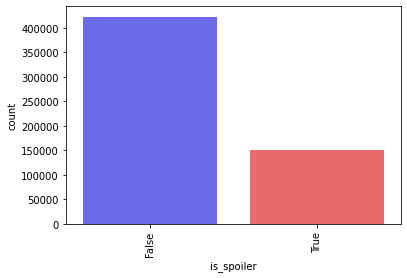

In [7]:
sns.countplot(x=train_data.is_spoiler, order=[x for x, count in sorted(Counter(train_data.is_spoiler).items(), key=lambda x: -x[1])], palette="seismic")
plt.xticks(rotation=90);

In [8]:
spoiler_data = train_data[train_data["is_spoiler"]==True][:10000]
non_spoiler_data = train_data[train_data["is_spoiler"]==False][:10000]

In [9]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

#Combine spoiler and non_spoiler dataset
all_data = pd.concat([spoiler_data, non_spoiler_data], ignore_index=True)

# Shuffle data
all_data = all_data.sample(frac=1)

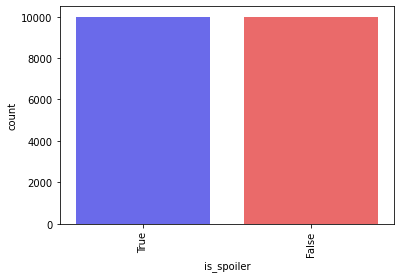

In [12]:
sns.countplot(x=all_data.is_spoiler, order=[x for x, count in sorted(Counter(all_data.is_spoiler).items(), key=lambda x: -x[1])], palette="seismic")
plt.xticks(rotation=90);

In [13]:
def plot_most_common_features(text_col, target_col, n_features=50):
    from matplotlib import interactive

    df = pd.DataFrame({"review_text": text_col, "CLASS": target_col})
    grouped = df.groupby(["CLASS"]).apply(lambda x: x["review_text"].sum())
    grouped_df = pd.DataFrame({"CLASS": grouped.index, "review_text": grouped.values})

    from nltk.tokenize import WhitespaceTokenizer
    tokenizer = WhitespaceTokenizer()

    for ii, text in enumerate(grouped_df.review_text):
        pd.DataFrame(tokenizer.tokenize(text)).apply(pd.value_counts).head(n_features).plot(kind="bar", cmap=plt.cm.seismic, figsize=(20,5))
        plt.title(grouped_df.CLASS[ii], fontsize=20)
        plt.xticks(fontsize=15)
        plt.legend([])
        interactive(True)
        plt.show()

In [14]:
from nltk.stem import *
from nltk.corpus import stopwords

import re

def process_text(raw_text):

    letters_only = re.sub("[^a-zA-Z]", " ",raw_text) 
    words = letters_only.lower().split()
    
    stops = set(stopwords.words("english")) 
    not_stop_words = [w for w in words if not w in stops]
    
    stemmer = PorterStemmer()
    stemmed = [stemmer.stem(word) for word in not_stop_words]
    
    return( " ".join( stemmed ))  

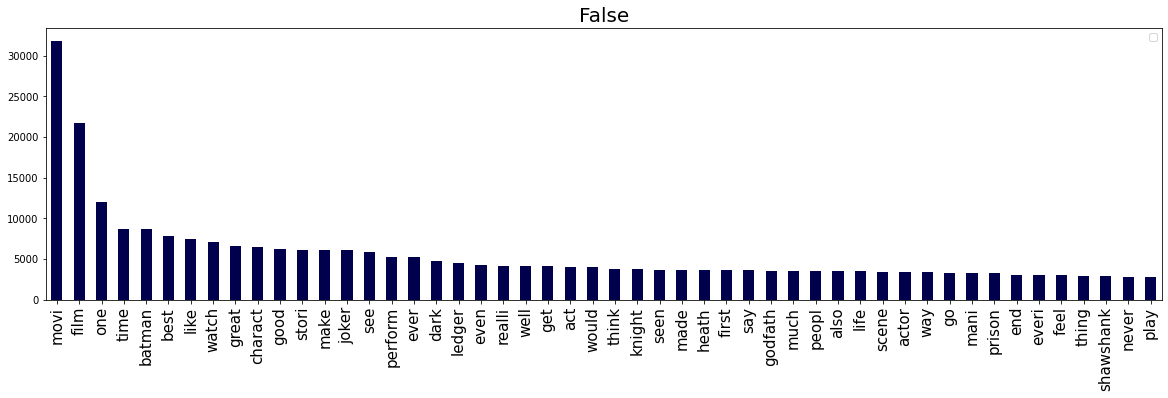

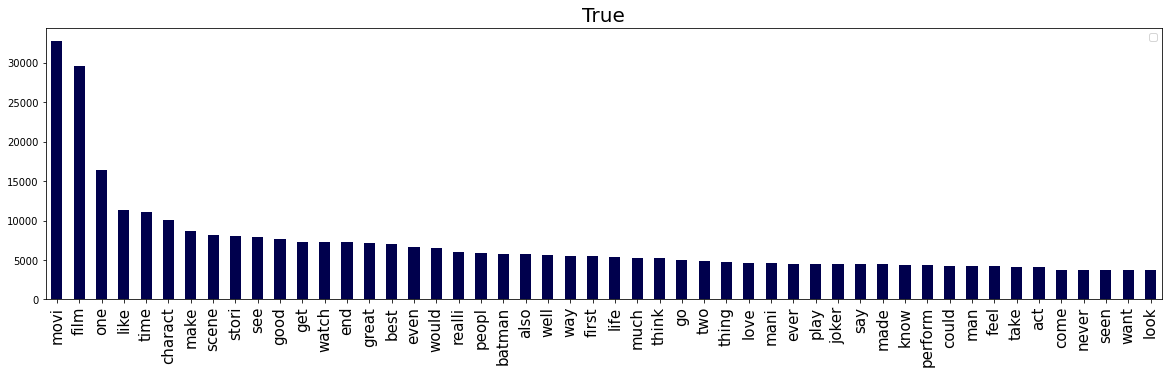

In [15]:
all_data['clean_text'] = all_data['review_text'].apply(lambda x: process_text(x))
plot_most_common_features(all_data.clean_text, all_data.is_spoiler)

In [16]:
def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!:.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)


    return text

In [17]:
def process_text(raw_text):
    
    # raw_text = text_to_word_list(raw_text)
    letters_only = re.sub("[^a-zA-Z]", " ",raw_text) 
    words = letters_only.lower().split()
    
    stops = set(stopwords.words("english"))  
    not_stop_words = [w for w in words if not w in stops]
    
    stemmer = PorterStemmer()
    stemmed = [stemmer.stem(word) for word in not_stop_words]
    
    return( " ".join( stemmed )) 

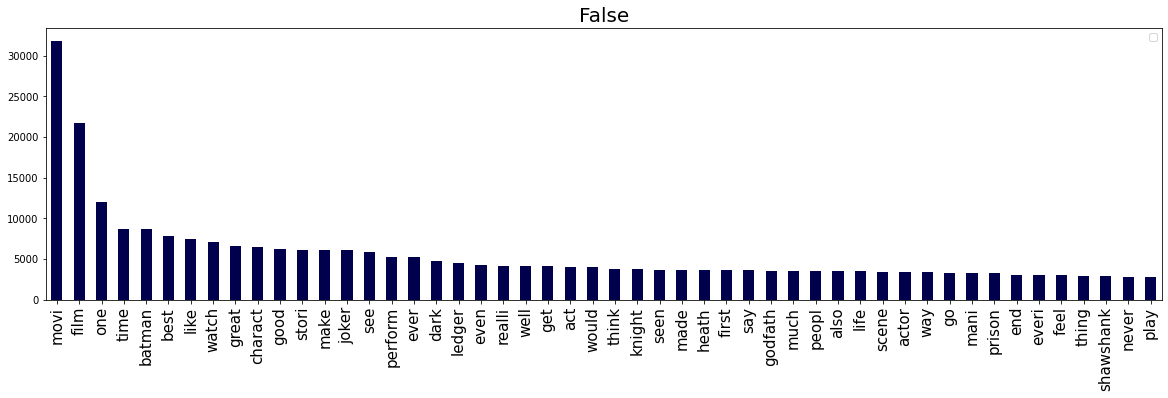

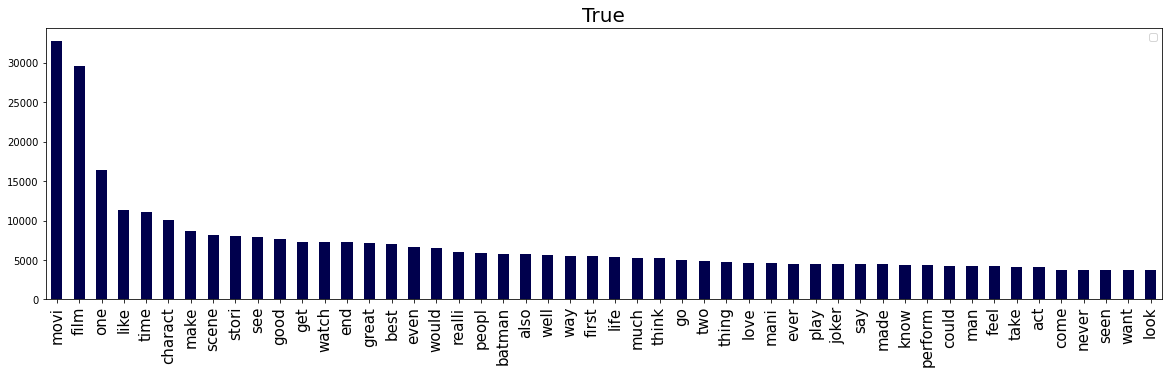

In [20]:
all_data['clean_text'] = all_data['review_text'].apply(lambda x: process_text(x))
plot_most_common_features(all_data.clean_text, all_data.is_spoiler)

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(all_data[["clean_text"]], all_data[["is_spoiler"]],
                                                    stratify=all_data[["is_spoiler"]], 
                                                    test_size=0.2)

In [23]:
# Hot encoding for the labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_train.is_spoiler.values)
target_labels = le.classes_
encoded_y_train = le.transform(y_train.is_spoiler.values)
encoded_y_test = le.transform(y_test.is_spoiler.values)

In [24]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

In [25]:
le_name_mapping

{False: 0, True: 1}

In [26]:
count_vect = CountVectorizer(analyzer = "word")
train_features = count_vect.fit_transform(X_train['clean_text'])
test_features = count_vect.transform(X_test['clean_text'])

tfidf = TfidfTransformer(norm="l2")
train_text_tfidf_features = tfidf.fit_transform(train_features)
test_text_tfidf_features = tfidf.fit_transform(test_features)      

In [27]:
def train_and_evaluate_classifier(X, yt, estimator, grid):
    """Train and Evaluate a estimator (defined as input parameter) on the given labeled data using accuracy."""
    
    # Cross validation
    from sklearn.model_selection import ShuffleSplit
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
      
    from sklearn.model_selection import GridSearchCV
    grid_search = GridSearchCV(estimator=estimator, cv=cv,  param_grid=grid, error_score=0.0, n_jobs = -1, verbose = 0)
    
    # Train the model over and tune the parameters
    print("Training model")
    grid_search.fit(X, yt)

    # CV-score
    print("Best score: %0.3f" % grid_search.best_score_)
    if len(grid) > 0:
      best_parameters = grid_search.best_estimator_.get_params()
      print("Best parameters set: ")
      print(best_parameters)
        

    return grid_search

In [28]:
nb_text_cls = train_and_evaluate_classifier(train_text_tfidf_features, encoded_y_train, MultinomialNB(), {})

Training model
Best score: 0.799


In [29]:
pred = nb_text_cls.predict(test_text_tfidf_features)

In [30]:
pred

array([0, 0, 0, ..., 0, 1, 0])

In [31]:
test_result = list(map(lambda x: False if x==0 else True, pred))

In [34]:
X_test.head()

,clean_text
2348,firstli let stress great movi enjoy excit inte...
14366,epic adventur corleon famili vito want get inv...
10538,good point movi alreadi state post stick point...
3717,movi well done show fiction certain glamor blo...
8302,probabl best action film time ingredi consid b...


In [35]:
y_test.head()

,is_spoiler
2348,True
14366,False
10538,False
3717,True
8302,True


In [48]:
X_test['clean_text'][8302]

'probabl best action film time ingredi consid best best first back ultim movi spectacular f x action sequenc nowaday movi look date still manag shock surreal nightmarish post apocalyt set monstruou robot action f x great great best thing movi termin spend lot effort fantast plot charact develop need extrem use f x charact interest background realli get plot simpli great futurist tale involv end world hand technolog time war human machin action non stop let want enough arnold co spectacular gun amaz explos memor chase sequenc freeway motorcycl etc movi rank high fun factor entertain factor arnold schwarzenegg deliv kickass perform everi time say hasta la vista babi problema trademark line skin crawl part pop cultur fit perfect movi feel linda hamilton sexi hell deliv brave solid perform special mention edward furlong deliv great perform robert patrick steal show villain impress jame cameron creat one best movi time bring us best possibl action ever seen movi also room gloriou gore non s

In [37]:
y_test['is_spoiler'][2348]

True

In [47]:
nb_text_cls.score(test_text_tfidf_features, encoded_y_test)

0.806

In [57]:
def predict(text, model):
  text_feature = count_vect.transform(text)
  text_tfidf_feature = tfidf.fit_transform(text_feature)
  
  pred = model.predict(text_tfidf_feature)
  # print custom response
  if (pred.item()==1):
      print("Spoiler!")
  elif (pred.item()==0):
      print("Not Spoiler!")

In [58]:
text = "probabl best action film time ingredi consid best best first back ultim movi spectacular f x action sequenc nowaday movi look date still manag shock surreal nightmarish post apocalyt set monstruou robot action f x great great best thing movi termin spend lot effort fantast plot charact develop need extrem use f x charact interest background realli get plot simpli great futurist tale involv end world hand technolog time war human machin action non stop let want enough arnold co spectacular gun amaz explos memor chase sequenc freeway motorcycl etc movi rank high fun factor entertain factor arnold schwarzenegg deliv kickass perform everi time say hasta la vista babi problema trademark line skin crawl part pop cultur fit perfect movi feel linda hamilton sexi hell deliv brave solid perform special mention edward furlong deliv great perform robert patrick steal show villain impress jame cameron creat one best movi time bring us best possibl action ever seen movi also room gloriou gore non stop violenc els much say truli recommend everyon one movi chang point view toward cinema"

In [59]:
predict([text], nb_text_cls)

Not Spoiler!


In [60]:
# LR model
from sklearn.linear_model import LogisticRegression

# Your code here
# params = {"gamma": ['scale'],
#           "C": [1],
#           "kernel": ['rbf']}
lr_text_cls = train_and_evaluate_classifier(train_text_tfidf_features, encoded_y_train, LogisticRegression(random_state=42), {})

Training model
Best score: 0.805


In [72]:
text = "This is spoiler review! Jon Snow kills dany in the end season of GOT"

In [73]:
predict([text], lr_text_cls)

Spoiler!


In [ ]:
train_data[train_data["is_spoiler"]==True].tail

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
573640,29 September 1999,tt0139239,ur0191545,True,"Since when is crime without punishment supposed to be funny? This movie is just not funny. I have a great sense of humor, I like noire-comedies. Doing drugs is just not funny! The contents of the movie are not good. A bunch of kids, who cuss a lot, doing drugs and are in the business of selling drugs. . . They are cute kids, but they are losers. I hope people do not think that everybody whom: (1) drives drunk, (2) sells drugs, (3) shoots at the police, (4) accidentally runs over a pedestrian, is going to do all that and go back to work two days later is mistaken! They will end up i...",1,Spoiler Warning! It was a mistake to have rented this trash! Stay away from this one.
573641,3 October 2006,tt0139239,ur5023752,True,"The film without a doubt has traces of ""Pulp Fiction"" embedded in it, but a little ""Swingers"" and other films to it as well. All in all it's an entertaining movie that goes nowhere and ends without an epiphany for these characters. This film has multiple stories that all relate with one another in some form that does not try to be alternative and cool. It doesn't condescend to its audience and it's always one step ahead of itself. Sarah Polley (whom I never heard of at the time but follow her work now) was great; Katie Holmes wasn't quite Katie Holmes, and that was good (although she is pr...",7,"""Pulp Fiction""-lite..."
573642,28 November 2000,tt0139239,ur0256124,True,"This movie is a lame attempt at trying to be Pulp Fiction. Only it lacked any real cajones, and was completely impossible in many points. SPOILER ALERT The drug dealer's character was a lame attempt at being a Samuel L. Jackson -type, only a skinny white boy with not even a tattoo to make him look tough. And what was up with that 30 second ""take the shirt off and turn around while the music plays, then cut the music..."" crap? Trying too hard, are we?And the whole set-up thing with the girl! How dumb is she? A) don't deal a lot of drugs to new people, B) when you show up, and there's a...",1,making my generation look dumber
573643,16 February 2014,tt0139239,ur3886859,True,"I got this movie around a year ago... yes it took me some time to watch it(which i did tonight). The reason is simple, i got it as part of my obsession for teen comedies. Yes the kind of Superbad, American Pie, College, Van Wilder and so on. I learn afterword on IMDb that it was actually not a comedy at all, more like a serious movie with a good scenario. I waited for he right occasion and i did tonight.So lets just say people where exactly true on IMDb and the cover arts are really misleading cause despise a few things in the middle, it ain't a comedy at all. I was really surprised when t...",6,"Deceiving cover, not a bad movie but..."
573644,20 May 2003,tt0139239,ur2427140,True,If you haven't heard any spoilers about this film go out and see it before someone ruins it for you.Its a great film with a great cast especially the sexy Katie Holmes 8/10 on a good day see this movie,10,Great film to see


In [ ]:
train_data["review_text"][573642]

'This movie is a lame attempt at trying to be Pulp Fiction.  Only it lacked any real cajones, and was completely impossible in many points. SPOILER ALERT The drug dealer\'s character was a lame attempt at being a Samuel L. Jackson -type, only a skinny white boy with not even a tattoo to make him look tough.  And what was up with that 30 second "take the shirt off and turn around while the music plays, then cut the music..." crap?  Trying too hard, are we?And the whole set-up thing with the girl!  How dumb is she?  A) don\'t deal a lot of drugs to new people, B) when you show up, and there\'s a 3rd guy there, DON\'T SELL THE STUFF, C)when they say they\'re out of o.j., JUST WALK OUT THE FRONT DOOR YOU CAME IN!  They can\'t make you stay!  Never would happen that way in real life.  Just lacked reality, and thus the "drama" was lost.Next, the strip-club thing.  1) a bouncer wouldn\'t be THAT upset that you used hands, I\'m sure it happens all the time, they\'d probably just throw you out 

In [63]:
lr_text_cls.score(test_text_tfidf_features, encoded_y_test)

0.80725

In [ ]:
!pip install fastai==2.0.15
!pip install fastai2==0.0.30
!pip install fastcore==1.0.16.

     |████████████████████████████████| 194kB 18.3MB/s 
     |████████████████████████████████| 61kB 7.4MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


     |████████████████████████████████| 184kB 19.1MB/s 
     |████████████████████████████████| 40kB 5.3MB/s 
  Found existing installation: fastcore 1.3.19
    Uninstalling fastcore-1.3.19:
      Successfully uninstalled fastcore-1.3.19


In [ ]:
from fastai.basics import *
from fastai.callback.all import *
from fastai.text.all import *

In [ ]:
dls_lm = DataBlock(
    blocks=TextBlock.from_df('text', is_lm=True),
    get_x=ColReader('text'),
    splitter=RandomSplitter(0.1)
).dataloaders(train_data, bs=64, seq_len=40)

dls_lm.show_batch(max_n=5)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


AttributeError: ignored

In [ ]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

In [ ]:
learn.lr_find(start_lr=1e-6, end_lr=1)